In [1]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [2]:
TRAIN_DATA_DIR = "data/train"
CLASS_DICT = "data/class_dict.csv"

class_df = pd.read_csv(CLASS_DICT)
class_rgb_values = class_df[['r', 'g', 'b']].values.tolist()
class_names = class_df['name'].tolist()
n_classes = len(class_names)

# original images are 2448x2448. we can use these constants to control their scaling.
IMG_HEIGHT, IMG_WIDTH = 512, 512

In [36]:
class DeepGlobeDataset(Dataset):
    def __init__(self, data_dir, class_rgb_values, img_size):
        self.image_paths = sorted(glob(os.path.join(data_dir, '*_sat.jpg')))
        self.mask_paths  = sorted(glob(os.path.join(data_dir, '*_mask.png')))
        self.class_rgb_values = class_rgb_values
        self.img_size = img_size  # (W, H)
        self.img_to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # --- Load & resize image ---
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = img.resize(self.img_size, resample=Image.Resampling.BILINEAR)

        # --- Load & resize mask ---
        mask = Image.open(self.mask_paths[idx]).convert('RGB')
        mask = mask.resize(self.img_size, resample=Image.Resampling.NEAREST)

        img_t = self.img_to_tensor(img)   # float32, (3,H,W) in [0,1]

        mask_np = np.array(mask)                   # (H,W,3), uint8
        mask_np = self.rgb_to_class(mask_np)  # (H,W), uint8
        mask_t = torch.from_numpy(mask_np).long()  # (H,W), int64

        return img_t, mask_t
    
    def rgb_to_class(self, mask):
        """
        Convert (H, W, 3) RGB mask to (H, W) class-index mask.
        """
        semantic_map = np.zeros(mask.shape[:2], dtype=np.uint8)
        for idx, color in enumerate(self.class_rgb_values):
            semantic_map[np.all(mask == color, axis=-1)] = idx
        return semantic_map


In [45]:
dataset = DeepGlobeDataset(
    data_dir=TRAIN_DATA_DIR,
    class_rgb_values=class_rgb_values,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=(device.type=="cuda"))


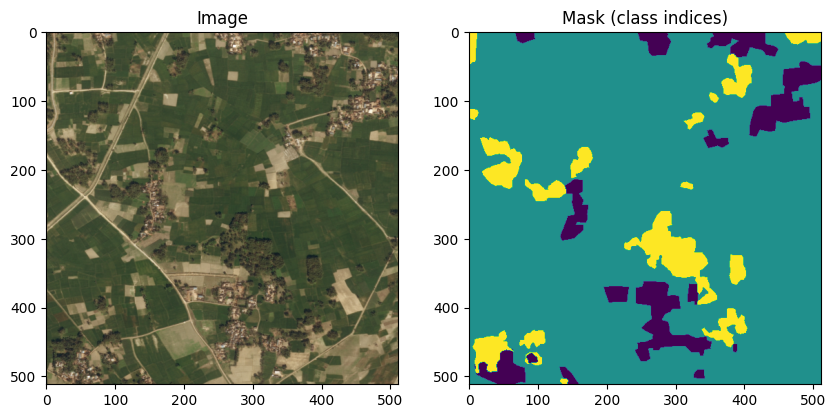

In [47]:
# example visualization 
images,masks = next(iter(loader))
img = images[0].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
mask = masks[0].cpu().numpy()                   # (H, W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")


plt.subplot(1,2,2)
plt.imshow(mask)  # categorical mask
plt.title("Mask (class indices)")
plt.show()